In [1]:
import sys
sys.path.append('../src/')
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import cv2
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import look_at_view_transform

from tools import render_pc_image
from tools import hidden_pts_removal
from tools import get_cam_frustum_pts

INFO - 2021-01-24 12:58:01,176 - topics - topicmanager initialized


In [2]:
class FrustumVisibility(torch.autograd.Function):

    @staticmethod
    def forward(ctx, rewards, fov_mask):
        rewards_fov = rewards * fov_mask
        
        ctx.save_for_backward(fov_mask)
        return torch.sum(rewards_fov)

    @staticmethod
    def backward(ctx, grad_output):
        fov_mask, = ctx.saved_tensors
        d_rewards = grad_output.clone() * fov_mask
        return d_rewards, None

In [3]:
class Model(nn.Module):
    def __init__(self, points, dist_init, elev_init, azim_init):
        super().__init__()
        self.points = points
        self.device = points.device

        # Create optimizable parameters for pose of the camera.
        self.camera_dist_elev_azim = nn.Parameter(
            torch.as_tensor([dist_init, elev_init, azim_init], dtype=torch.float32).to(points.device))

        self.K, self.width, self.height = self.load_intrinsics()
        self.eps = 1e-6
        
        self.frustum_visibility = FrustumVisibility.apply

    @staticmethod
    def load_intrinsics():
        width, height = 1232., 1616.
        K = torch.tensor([[758.03967, 0.,        621.46572, 0.],
                          [0.,        761.62359, 756.86402, 0.],
                          [0.,        0.,        1.,        0.],
                          [0.,        0.,        0.,        1.]]).to(device)
        K = K.unsqueeze(0)
        return K, width, height
    
    @staticmethod
    def get_dist_mask(points, min_dist=1.0, max_dist=10.0):
        # clip points between MIN_DIST and MAX_DIST meters distance from the camera
        dist_mask = (points[2] > min_dist) & (points[2] < max_dist)
        return dist_mask
    
    @staticmethod
    def get_fov_mask(points, img_height, img_width, intrins):
        # find points that are observed by the camera (in its FOV)
        pts_homo = intrins[:3, :3] @ points
        pts_homo[:2] /= pts_homo[2:3]
        fov_mask = (pts_homo[2] > 0) & \
                   (pts_homo[0] > 1) & (pts_homo[0] < img_width - 1) & \
                   (pts_homo[1] > 1) & (pts_homo[1] < img_height - 1)
        return fov_mask

    def to_camera_frame(self, verts, R, T):
        R_inv = R.squeeze().T
        verts_cam = R_inv @ (verts - torch.repeat_interleave(T, len(verts), dim=0).to(self.device)).T
        verts_cam = verts_cam.T
        return verts_cam

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the
        # camera we calculate the rotation and translation matrices
        distance, elevation, azimuth = self.camera_dist_elev_azim
        R, T = look_at_view_transform(distance, elevation, azimuth, device=self.device)

        # transform points to camera frame
        verts = self.to_camera_frame(self.points, R, T)

        # get masks of points that are inside of the camera FOV
        dist_mask = self.get_dist_mask(verts.T, 1.0, 10.0)
        fov_mask = self.get_fov_mask(verts.T, self.height, self.width, self.K.squeeze(0))
        mask = torch.logical_and(dist_mask, fov_mask)
        
        # remove points that are outside of camera FOV
        verts = verts[mask, :]
        
        # HPR: remove occluded points
        # verts = hidden_pts_removal(verts.detach(), device=self.device)
        
        rewards = self.distance_rewards()
        loss = self.criterion(rewards, mask)
        return verts, loss

    @staticmethod
    def gaussian(x, mu=2.0, sigma=4.0):
        # https://en.wikipedia.org/wiki/Normal_distribution
        g = torch.exp(-0.5*((x - mu)/sigma)**2) / (sigma * torch.sqrt(torch.tensor(2*np.pi)))
        return g
    
    def distance_rewards(self):
        # get camera location
        distance, elevation, azimuth = self.camera_dist_elev_azim
        _, T = look_at_view_transform(distance, elevation, azimuth, device=self.device)
        # compute rewards based on distance of the surrounding points
        dists = torch.linalg.norm(T - self.points, dim=1)
        rewards = self.gaussian(dists)
        return rewards
        
    def criterion(self, rewards, mask):
        # transform rewards to loss function
        #loss = 1. / (torch.sum(rewards) + self.eps)
        loss = 1. / (self.frustum_visibility(rewards, mask) + self.eps)
        return loss

### Load point cloud

In [4]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# Set paths
obj_filename = "../../../../catkin_ws/src/frontier_exploration/pts/cam_pts_camera_0_1607456676.1540315.npz"
# obj_filename = "../../../../catkin_ws/src/frontier_exploration/pts/cam_pts_camera_0_1607456663.5413494.npz"
# Load point cloud
pts_np = np.load(obj_filename)['pts'].transpose()
verts = torch.tensor(pts_np).to(device)
# rgb = (verts - torch.min(verts)) / torch.max(verts - torch.min(verts)).to(device)
rgb = torch.zeros_like(verts)

point_cloud = Pointclouds(points=[verts], features=[rgb])

### Point cloud rendering parameters

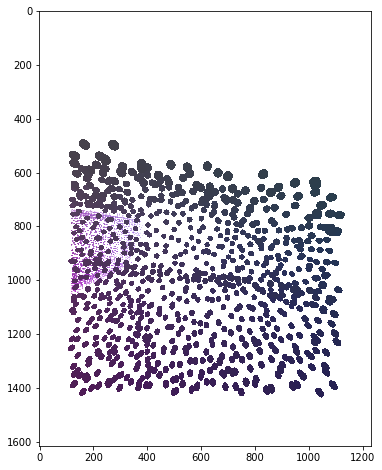

In [5]:
# Camera intrinsics
cam_info_K = (758.03967, 0.0, 621.46572, 0.0, 761.62359, 756.86402, 0.0, 0.0, 1.0)
width, height = 1232, 1616
K = torch.tensor([[758.03967, 0.,        621.46572, 0.],
                  [0.,        761.62359, 756.86402, 0.],
                  [0.,        0.,        1.,        0.],
                  [0.,        0.,        0.,        1.]]).to(device)
K = K.unsqueeze(0)

# Initialize a camera.
R = torch.eye(3).unsqueeze(0).to(device)
T = torch.Tensor([[0., 0., 0.]]).to(device)

image = render_pc_image(verts, R, T, K, height, width, device)

plt.figure(figsize=(8, 8))
plt.imshow(image.cpu().numpy());

### Define the model

In [6]:
# Initialize a model
model = Model(points=verts,
              dist_init=-1.0,
              elev_init=10,
              azim_init=30).to(device)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Optimization loop

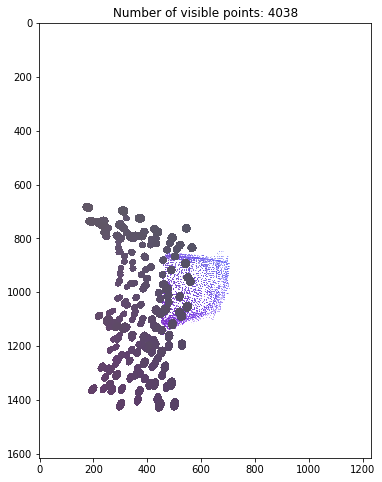

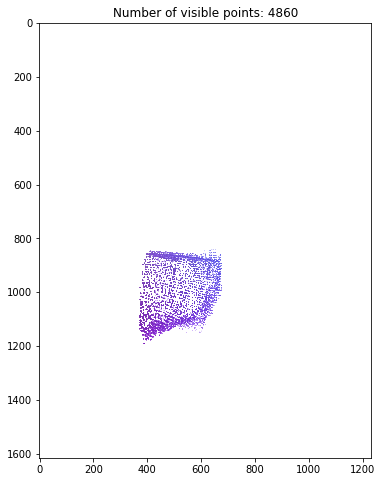

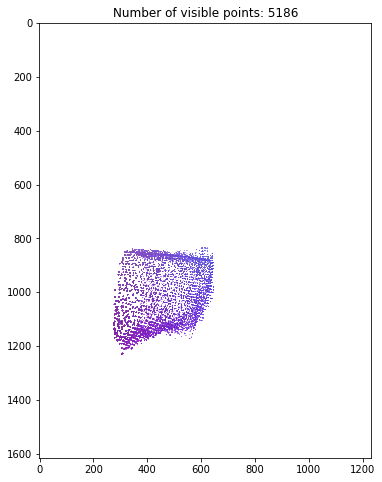

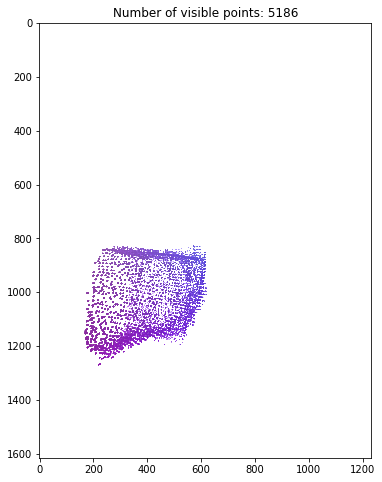

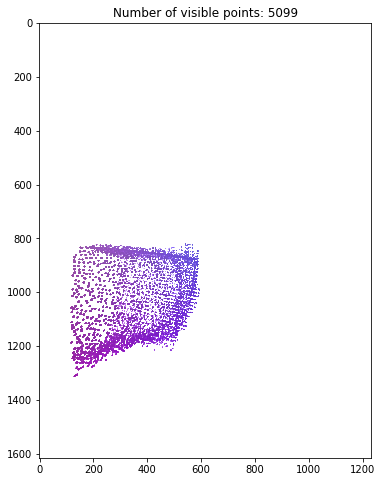

In [7]:
# Run optimization loop
loop = tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    verts, loss = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if i % 20 == 0:
        image = render_pc_image(verts, R, T, K, height, width, device)

        plt.figure(figsize=(8, 8))
        plt.imshow(image.detach().cpu().numpy());
        plt.title(f'Number of visible points: {verts.size()[0]}')
        plt.show()